In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import pickle
from functions_variables import *

## Import final dataset

In [2]:
X_train = pd.read_csv('../data/final/X_train.csv')
X_test = pd.read_csv('../data/final/X_test.csv')

X_train_scaled = pd.read_csv('../data/final/X_train_scaled.csv')
X_test_scaled = pd.read_csv('../data/final/X_test_scaled.csv')
y_train = pd.read_csv('../data/final/y_train.csv')
y_test = pd.read_csv('../data/final/y_test.csv')

### Get predicted values to be used for backtesting

In [3]:
model = xgb.XGBClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

### Import the same scaler used to scale the data originally so I can unscale them properly

In [7]:
with open('../data/final/scalar.pkl', 'rb') as f:
    scaler = pickle.load(f)
    
# Unscale the data back to its original scale
X_test_unscaled = scaler.inverse_transform(X_test_scaled)

# Convert back to a DataFrame if needed
X_test_unscaled_df = pd.DataFrame(X_test_unscaled, columns=X_test_scaled.columns)

### Unscaled data results in the same as X_test and will be used for back testing

In [48]:
df = X_test_unscaled_df[['TSX']]
df.loc[:, 'Predict'] = y_pred

/var/folders/vl/xjjnctgs1s30y4rth02ltgm00000gn/T/ipykernel_78523/338040211.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Predict'] = y_pred


<p>Set initial seed of $1M and zero shares of the TSX. The TSX is an index, so you can't really trade, except through an ETF, which is why I started with a seed investment of $1M since the index starts at 20,795.</p>

In [41]:
# $1,000,000
investment = 1000000
shares = 0

# Initialize columns
df['Cummulative Investment'] = 0
df['Shares Held'] = 0
df['Action'] = ''
df['Buy'] = 0

/var/folders/vl/xjjnctgs1s30y4rth02ltgm00000gn/T/ipykernel_78523/1065096431.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cummulative Investment'] = 0
/var/folders/vl/xjjnctgs1s30y4rth02ltgm00000gn/T/ipykernel_78523/1065096431.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Shares Held'] = 0
/var/folders/vl/xjjnctgs1s30y4rth02ltgm00000gn/T/ipykernel_78523/1065096431.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

## Back Testing

#### Trading Strategy
<p>The trading strategy employed for this model is to do the following:</p>

- If the model predicts the index will go down - Purchase one share
- If the model predicts the index will go up:
    - Sell all shares if the shares held have an average price below the current close price
    - Hold if no shares held or average price is above current close price



<p>Iterate over TSX value and prediction to calculate the appropriate trade, cummulative investment, trade action, shares held using a custom built trade function</p>

In [42]:
for index, row in df.iterrows():
    if index > 0:  # Ensure there is a prior row
        open = df.loc[index - 1, 'TSX'] 
        investment, shares, action, avg = trade(open, row['TSX'], index - 1, df, shares, investment, row['Predict'])
        df.loc[index, 'Cummulative Investment'] = investment 
        df.loc[index, 'Shares Held'] = shares 
        df.loc[index, 'Action'] = action 
        df.loc[index, 'Average Price'] = avg
        if action == 'buy':
            df.loc[index, 'Buy'] = row['TSX']


/Users/kennethwall/Documents/Data Science/Projects/LHL-Final-Project-Stock-Price-Prediction/notebooks/functions_variables.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Group'] = (df['Buy'] == 0).cumsum()
/var/folders/vl/xjjnctgs1s30y4rth02ltgm00000gn/T/ipykernel_78523/1055927354.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'Average Price'] = avg
/Users/kennethwall/Documents/Data Science/Projects/LHL-Final-Project-Stock-Price-Prediction/notebooks/functions_variables.py:213: S

In [43]:
df['Buy'] = df['Buy'].fillna(0)

/var/folders/vl/xjjnctgs1s30y4rth02ltgm00000gn/T/ipykernel_78523/1963523397.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Buy'] = df['Buy'].fillna(0)


In [44]:
df.tail() # ensure that the trade function is calclating everything correctly. All Good!!

,TSX,Predict,Cummulative Investment,Shares Held,Action,Buy,Group,Average Price
657,21255.61,1,1026445.33,0,hold,0.00,375,inf
658,21217.53,1,1026445.33,0,hold,0.00,376,inf
659,21172.38,0,1005217.80,1,buy,21172.38,376,inf
660,21318.08,1,1026525.88,0,sell,0.00,377,21172.38
661,21413.15,1,1026525.88,0,hold,0.00,378,inf


In [45]:
num_trading_days = 252
num_days_test_set = df.shape[0]

total_return = df['Cummulative Investment'].iloc[-1] - 1000000
final_position = df['Shares Held'].iloc[-1] * df['TSX'].iloc[-1]

total_return = total_return + final_position
total_per_return = total_return / 1000000 * 100
annualized_per_return = (1 + total_per_return) ** (num_trading_days / num_days_test_set) - 1

print(f'Total gain for backtested prediction on test set was {total_return:,.2f}')
print(f"Total % return is: {(total_per_return):.2f}%")
print(f"Total annualized % return is: {(annualized_per_return):.2f}%")



Total gain for backtested prediction on test set was 26,525.88
Total % return is: 2.65%
Total annualized % return is: 0.64%


Total gain for backtested model is $29,925.88 before fees. If you include $10 fees per trade which is common the total gain is reduced to $26,525. 

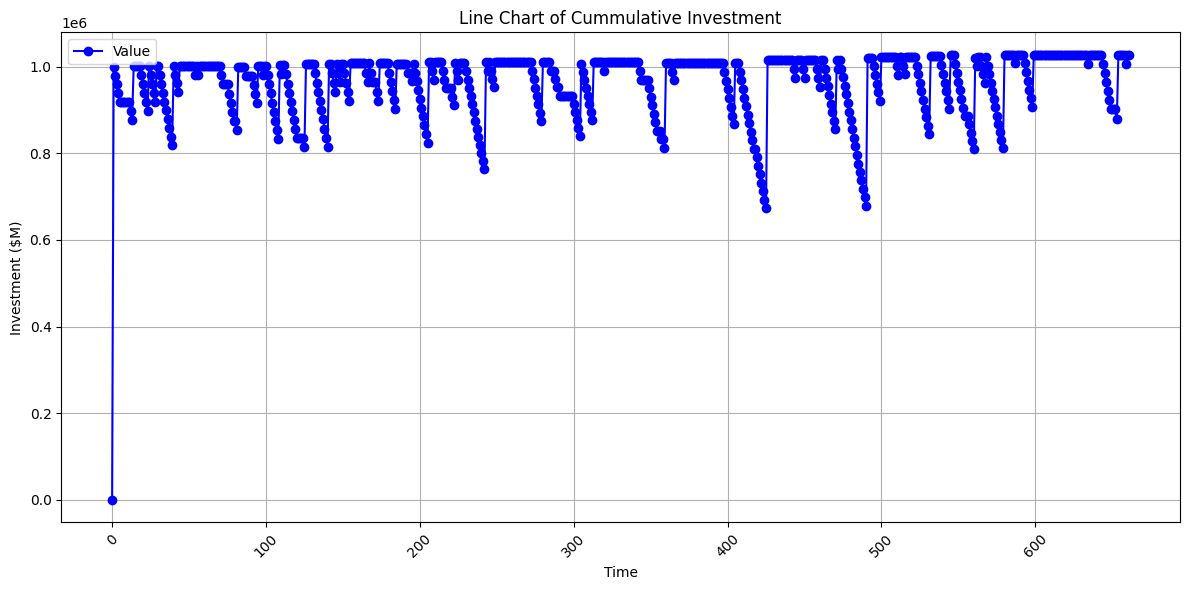

In [46]:
plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(df.index, df['Cummulative Investment'], marker='o', linestyle='-', color='b', label='Value')  # Plot the line chart

# Customize the plot
plt.title('Line Chart of Cummulative Investment')  # Set the title
plt.xlabel('Time')  # Label for x-axis
plt.ylabel('Investment ($M)')  # Label for y-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.grid(True)  # Show grid
plt.tight_layout()  # Adjust the padding between and around subplots

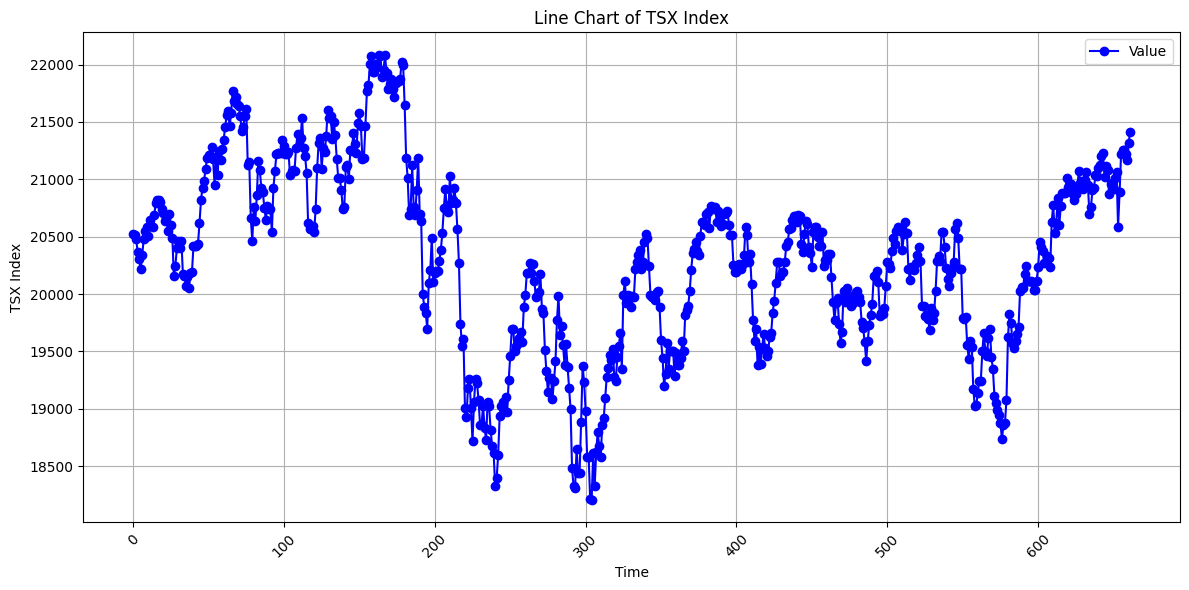

In [47]:
plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(df.index, df['TSX'], marker='o', linestyle='-', color='b', label='Value')  # Plot the line chart

# Customize the plot
plt.title('Line Chart of TSX Index')  # Set the title
plt.xlabel('Time')  # Label for x-axis
plt.ylabel('TSX Index')  # Label for y-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.grid(True)  # Show grid
plt.tight_layout()  # Adjust the padding between and around subplots